In [4]:
import pandas as pd
import joblib 
import numpy as np 


In [48]:
# ==========================================
# 1. INDICATORS & FEATURES 
# ==========================================
def calculate_basic_indicators(df):
    data = df.copy()
    data['ema_50'] = data['close'].ewm(span=50, adjust=False).mean()
    data['ema_200'] = data['close'].ewm(span=200, adjust=False).mean()
    
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    rs = gain / loss
    data['rsi_14'] = 100 - (100 / (1 + rs))
    
    if 'volume_usd' not in data.columns:
        data['volume_usd'] = data['close'] * data['volume']
    data['vol_ma20'] = data['volume_usd'].rolling(window=20).mean()
    return data

def calculate_smart_money_features(df):
    df_smc = df.copy()
    
    # ==========================================
    # 1. SETUP: Candle Anatomy
    # ==========================================
    
    # Body size (Absolute value)
    body_size = np.abs(df_smc['close'] - df_smc['open'])
    
    # Total range (High - Low)
    candle_range = df_smc['high'] - df_smc['low']
    
    # Upper and Lower Wicks
    # Upper Wick = High - Max(Open, Close)
    upper_wick = df_smc['high'] - df_smc[['open', 'close']].max(axis=1)
    # Lower Wick = Min(Open, Close) - Low
    lower_wick = df_smc[['open', 'close']].min(axis=1) - df_smc['low']
    
    # Calculate Shock Volume
    # Volume > 2x average of last 20 candles
    avg_vol = df_smc['volume'].rolling(window=20).mean()
    is_shock_vol = df_smc['volume'] > (2 * avg_vol)
    
    # ==========================================
    # 2. ORDER BLOCKS 
    # ==========================================
    
    # Bullish Pinbar, potential demand zone
    df_smc['is_bullish_ob'] = (
        (lower_wick > 2 * body_size) & # Long tail 
        (lower_wick > upper_wick) & # Tail is longer than nose
        (is_shock_vol) # Whales are active
    )
    
    # Bearish Pinbar, potential supply zone
    df_smc['is_bearish_ob'] = (
        (upper_wick > 2 * body_size) & # Long nose
        (upper_wick > lower_wick) &  # Nose is longer than tail
        (is_shock_vol) # Whales are active
    )
    
    # ==========================================
    # 3. FAIR VALUE GAPS (FVG) 
    # ==========================================
    
    
    prev_high = df_smc['high'].shift(2)
    prev_low = df_smc['low'].shift(2)
    
    threshold = df_smc['close'] * 0.0005
    
    
    bullish_gap_size = df_smc['low'] - prev_high
    
    # Bullish FVG: Low > Prev High
    df_smc['is_fvg_bullish'] = (
        (df_smc['low'] > prev_high) & # The Gap exists
        (bullish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] > df_smc['open']) # Current candle is green
    )
    
    bearish_gap_size = prev_low - df_smc['high']
    
    # Bearish FVG: High < Prev Low
    df_smc['is_fvg_bearish'] = (
        (df_smc['high'] < prev_low) & # The Gap exists
        (bearish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] < df_smc['open']) # Current candle is Red
    )
    
    # Clean up, fill NaNs with False
    
    cols_to_fill = ['is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
    df_smc[cols_to_fill] = df_smc[cols_to_fill].fillna(False)
    
    return df_smc

def create_wyckoff_features(df):
    df_w = df.copy()
    
    df_w['trend_maturity'] = (df_w['ema_50'] - df_w['ema_200']) / df_w['close'] * 100
    df_w['trend_tactical'] = (df_w['close'] - df_w['ema_50']) / df_w['ema_50'] * 100
    
    # Efficiency
    epsilon = 1e-9
    range_len = df_w['high'] - df_w['low'] 
    body_len = abs(df_w['close'] - df_w['open'])
    df_w['efficiency_regime'] = (body_len / (range_len + epsilon)).rolling(window=20).mean()
    
    # Volume Regime
    df_w['rel_volume'] = df_w['volume_usd'] / df_w['vol_ma20']
    df_w['vol_regime'] = df_w['rel_volume'].rolling(window=1).mean()
    
    # Structure Score
    structure_score = np.zeros(len(df_w))
    current_score = 0 
    decay = 0.98
    
    bull_ob = df_w['is_bullish_ob'].values.astype(int)
    bear_ob = df_w['is_bearish_ob'].values.astype(int)
    fvg_bull = df_w['is_fvg_bullish'].values.astype(int)
    fvg_bear = df_w['is_fvg_bearish'].values.astype(int)
    
    for i in range(1, len(df_w)):
        current_score *= decay
        if bull_ob[i]: current_score += 1.0
        if bear_ob[i]: current_score -= 1.0 
        if fvg_bull[i]: current_score += 0.5
        if fvg_bear[i]: current_score -= 0.5
        structure_score[i] = current_score
        
    df_w['structure_score'] = structure_score
    return df_w

# --- 2. DISCRETIZATION ---
def discretize_features(df, cluster_map):
    data = df.copy()
    
    # Bins
    data['RSI_Bin'] = pd.cut(data['rsi_14'], bins=[-np.inf, 30, 45, 55, 70, np.inf], labels=['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'])
    data['Vol_Bin'] = pd.cut(data['vol_regime'], bins=[-np.inf, 0.5, 1.5, 3.0, np.inf], labels=['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'])
    data['Trend_Bin'] = pd.cut(data['trend_tactical'], bins=[-np.inf, -0.6, -0.1, 0.1, 0.6, np.inf], labels=['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'])
    data['Struct_Bin'] = pd.cut(data['structure_score'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['Struct_Bear', 'Struct_Neutral', 'Struct_Bull'])
    
    # Phase Mapping
    if 'cluster' in data.columns:
        data['Phase_Label'] = data['cluster'].map(cluster_map)
    
    cols = ['open_time', 'close', 'cluster', 'Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin']
    return data[[c for c in cols if c in data.columns]].dropna()



In [49]:
# --- 3. MASTER GENERATOR ---
def generate_test_transactions(test_csv_path, model_path="Models/kmeans_wyckoff_model.pkl"):
    print("1. Loading Test Data...")
    df = pd.read_csv(test_csv_path)
    df['open_time'] = pd.to_datetime(df['open_time'])
    
    print("2. Generating Features...")
    df = calculate_basic_indicators(df)
    df = calculate_smart_money_features(df)
    df = create_wyckoff_features(df)
    
    print("3. Predicting Phases (Using Saved Model)...")
    try:
        kmeans = joblib.load(model_path)
        feature_cols = ["trend_tactical", "trend_maturity", "efficiency_regime", "vol_regime", "structure_score"]
        df_clean = df.dropna(subset=feature_cols).copy()
        
        df_clean['cluster'] = kmeans.predict(df_clean[feature_cols])
        
    except Exception as e:
        print(f"⚠️ Model Load Failed: {e}")
        print("Please ensure your 'Models/kmeans_wyckoff_model.pkl' exists.")
        return None


    cluster_map = {
        0: 'Phase_Markup',
        1: 'Phase_Accumulation',
        2: 'Phase_Climax',
        3: 'Phase_Markdown'
    }
    
    print("4. Discretizing...")
    return discretize_features(df_clean, cluster_map)



In [50]:
test_transactions = generate_test_transactions('Data/bitcoin_data_test.csv')
test_transactions.head()

1. Loading Test Data...
2. Generating Features...
3. Predicting Phases (Using Saved Model)...
4. Discretizing...


d:\Python\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,open_time,close,cluster,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin
19,2025-01-01 00:19:00,93796.35,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Bullish,Struct_Bull
20,2025-01-01 00:20:00,93866.00,1,Phase_Accumulation,RSI_Overbought,Vol_Normal,Trend_Bullish,Struct_Bull
21,2025-01-01 00:21:00,93800.00,2,Phase_Climax,RSI_Bullish,Vol_High,Trend_Bullish,Struct_Neutral
22,2025-01-01 00:22:00,93733.50,1,Phase_Accumulation,RSI_Neutral,Vol_Low,Trend_Neutral,Struct_Neutral
23,2025-01-01 00:23:00,93748.42,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Neutral,Struct_Neutral


In [51]:
test_transactions['Phase_Label'].value_counts()

Phase_Label
Phase_Accumulation    372818
Phase_Climax           99017
Phase_Markup           15185
Phase_Markdown          2561
Name: count, dtype: int64

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1092\3971747604.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='bfill')


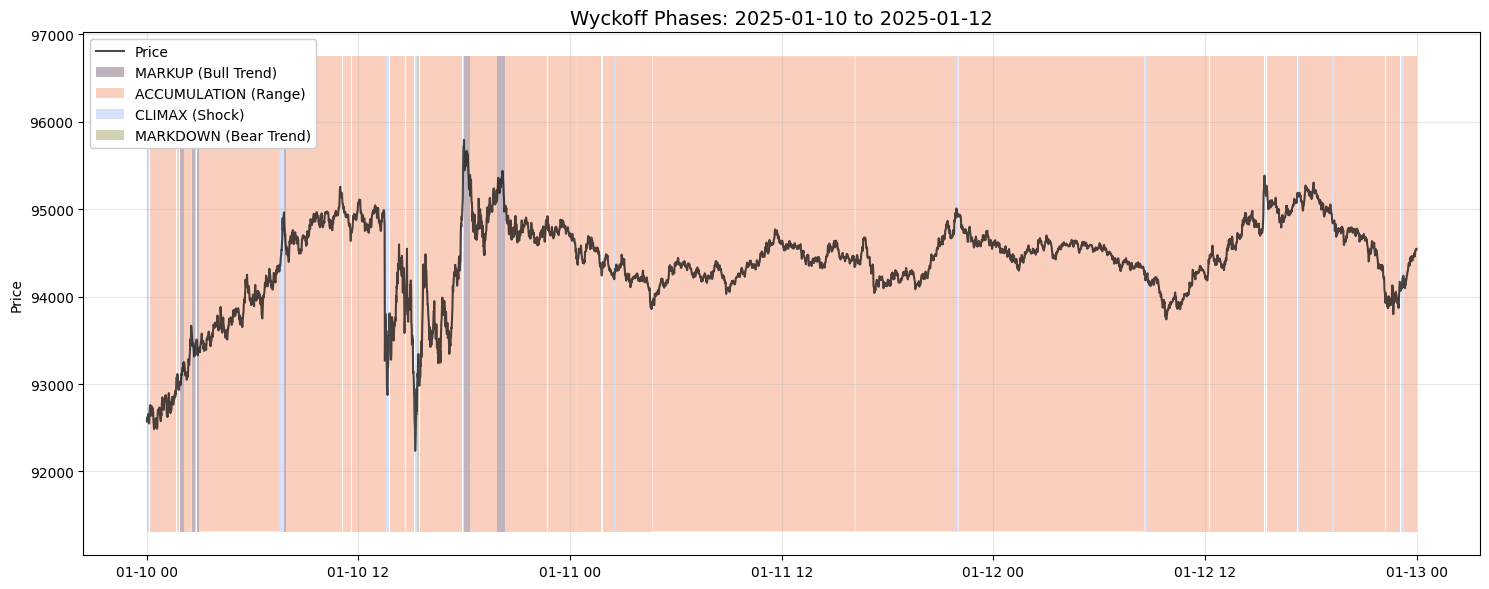

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_wyckoff_zoom(df, start_date, end_date, smooth_window=10):
    """
    Plots Price vs Wyckoff Clusters for a specific time interval.
    """
    # Ensure DateTime Index
    df_plot = df.copy()
    df_plot.set_index(pd.to_datetime(df['open_time']), inplace=True)
    
    
    # 1. Prepare Data Slice
    subset = df_plot.loc[start_date:end_date].copy()
    
    
    # 2. Apply Smoothing 
    subset['smooth_cluster'] = subset['cluster'].rolling(window=smooth_window).apply(
        lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else x[int(smooth_window/2)], 
        raw=True
    ).fillna(method='bfill')

    # 3. Define Colors 
    colors = {0: "#2b0527", 1: "#f5632a", 2: "#789cf0", 3: "#6d6b03"}
    labels = {0: 'MARKUP (Bull Trend)', 1: 'ACCUMULATION (Range)', 2: 'CLIMAX (Shock)', 3: 'MARKDOWN (Bear Trend)'}

    # 4. Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot Price Line
    ax.plot(subset.index, subset['close'], color='black', linewidth=1.5, alpha=0.7, label='Price')

    # Paint Background (Vectorized)
    for cluster_id, color in colors.items():
        mask = (subset['smooth_cluster'] == cluster_id)
        ax.fill_between(
            subset.index, 
            y1=subset['close'].min() * 0.99, # Dynamic Y-limits for the zoom
            y2=subset['close'].max() * 1.01, 
            where=mask, 
            color=color, alpha=0.3, 
            linewidth=0, step='mid',
            label=labels[cluster_id]
        )

    # Styling
    ax.set_title(f"Wyckoff Phases: {start_date} to {end_date}", fontsize=14)
    ax.set_ylabel("Price")
    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



plot_wyckoff_zoom(test_transactions ,'2025-01-10', '2025-01-12', smooth_window=10)